In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models-pytorch
!pip install rasterio
!pip install richdem

In [ ]:
import os
from pathlib import Path
import shutil

import numpy as np

import pandas as pd  
import rasterio

from rasterio.plot import show
import richdem as rd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch import FloatTensor


In [ ]:
# Root Directory
Image_Segmentation_Path = '/content/drive/My Drive/Image Segmentation/'

# Inputs/Sources

dataframes_path = Image_Segmentation_Path + "DataFrames/"
# with_gan_model = Image_Segmentation_Path + 'Models/FPN_3c_With_Gan.pth'
without_gan_model = Image_Segmentation_Path + 'Models/FPN_3c_Without.pth'
with_gan_model = Image_Segmentation_Path + 'Models/FPN_3c_With_GAN.pth'
# unet_without_gan = Image_Segmentation_Path + 'Models/resnet34.pth'
# test_dem_dataframe = dataframes_path + 'test_dem_dataframe.csv'

final_valid = dataframes_path + 'final_valid.csv'
final_test = dataframes_path + 'final_test.csv'

plot_train_path = Image_Segmentation_Path + "DataFrames/plot_train.csv"
plot_test_path = Image_Segmentation_Path + "DataFrames/plot_test.csv"

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
class Dataset(BaseDataset):    
    CLASSES = ['non-mound', 'mound']
    
    def __init__(
          self, 
          dirs):
        self.df = pd.read_csv(dirs)
        self.ids = self.df.index.to_list()

        # convert str names to class values on masks
        self.class_values = CLASSES = [0, 1]

    
    def __getitem__(self, i):
        # read data
        if self.df.at[i, 'origin'][-3:] == 'tif':
            with rasterio.open(self.df.at[i, 'origin']) as dem:
                dem_array = dem.read(1)

            with rasterio.open(self.df.at[i, 'hillshade']) as hillshade:
                hillshade_array = hillshade.read(1)

            with rasterio.open(self.df.at[i, 'slope']) as slope:
                slope_array = slope.read(1)

            with rasterio.open(self.df.at[i, 'mask']) as mask:
                mask_array = mask.read(1)
            mask_array = np.where(mask_array == 0.5, 0, mask_array)
            input_array = [dem_array, slope_array, hillshade_array]
            input_array = np.stack(input_array, axis=0).astype('float')
            input_array = FloatTensor(input_array)
            mask_array = FloatTensor(np.expand_dims(mask_array,axis=(0)))        
        return input_array, mask_array
      
    def __len__(self):
        return len(self.ids)

In [ ]:
class Testset(BaseDataset):
  """
  Args:
      images_dir (str): path to images folder
      class_values (list): values of classes to extract from segmentation mask
  """
    
    
  def __init__(
          self, 
          dirs):
    self.df = pd.read_csv(dirs)
    self.ids = self.df.index.to_list()
    
    # convert str names to class values on masks
    self.class_values = CLASSES = [1, 0]
    
  def __getitem__(self, i):
    # read data
    with rasterio.open(self.df.at[i, 'origin']) as dem:
      dem_array = dem.read(1)
      
    with rasterio.open(self.df.at[i, 'slope']) as slope:
      slope_array = slope.read(1)

    with rasterio.open(self.df.at[i, 'hillshade']) as hillshade:
      hillshade_array = hillshade.read(1)


    input_array = [dem_array, slope_array, hillshade_array]
    input_array = np.stack(input_array, axis=0).astype('float')
    input_array = FloatTensor(input_array)
    
    # input_array = FloatTensor(np.expand_dims(dem_array,axis=(0)))

    return input_array
      
  def __len__(self):
    return len(self.ids)

In [ ]:
threshold=0.4
test_dataset = Testset(plot_test_path)
valid_dataset = Dataset(plot_train_path)

In [ ]:
df = pd.read_csv(plot_test_path)

In [ ]:
FPN_3c_With_Gan = torch.load(with_gan_model)
FPN_3c_Without = torch.load(without_gan_model)

In [ ]:
pred=[]
dems = []
slopes = []
for i in range(len(valid_dataset)):
  dem_array = valid_dataset[i]  
  im = dem_array[0].unsqueeze(0).float()
  out =  FPN_3c_With_Gan.predict(im)
  out = out.squeeze().cpu().numpy()
  out[out >= 0.5] = 1
  out[out < 0.5] = 0
  pred.append(out)
  dems.append(im.squeeze().cpu().numpy()[2])
  slopes.append(im.squeeze().cpu().numpy()[1])
# print(np.unique(out))

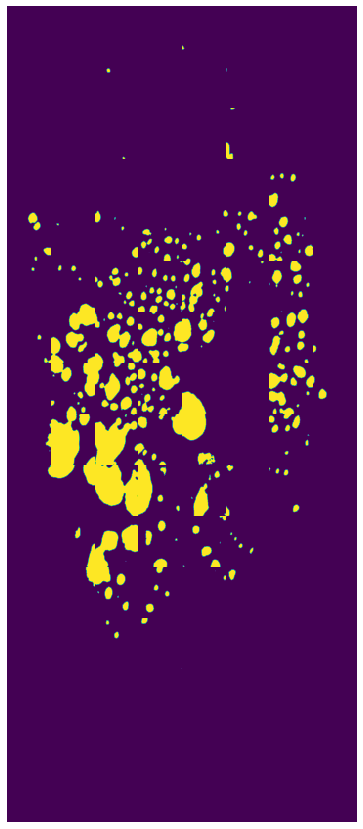

In [ ]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(16, 8),  # creates 16x8 grid of axes
                 axes_pad=0.0001,# pad between axes in inch.
                 direction = "column"
                 )

for ax, im in zip(grid, pred):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.imshow(im)

plt.show()

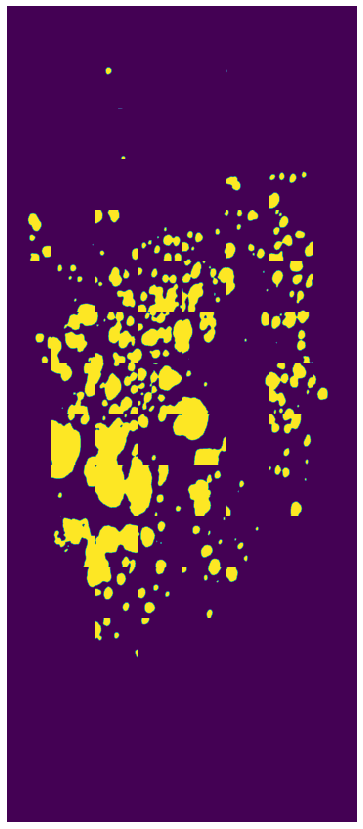

In [ ]:
pred=[]
dems = []
slopes = []
for i in range(len(valid_dataset)):
  dem_array = valid_dataset[i]  
  im = dem_array[0].unsqueeze(0).float()
  out =  FPN_3c_Without.predict(im)
  out = out.squeeze().cpu().numpy()
  out[out >= 0.5] = 1
  out[out < 0.5] = 0
  pred.append(out)
  dems.append(im.squeeze().cpu().numpy()[2])
  slopes.append(im.squeeze().cpu().numpy()[1])
# print(np.unique(out))
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(16, 8),  # creates 16x8 grid of axes
                 axes_pad=0.0001,# pad between axes in inch.
                 direction = "column"
                 )

for ax, im in zip(grid, pred):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.imshow(im)

plt.show()

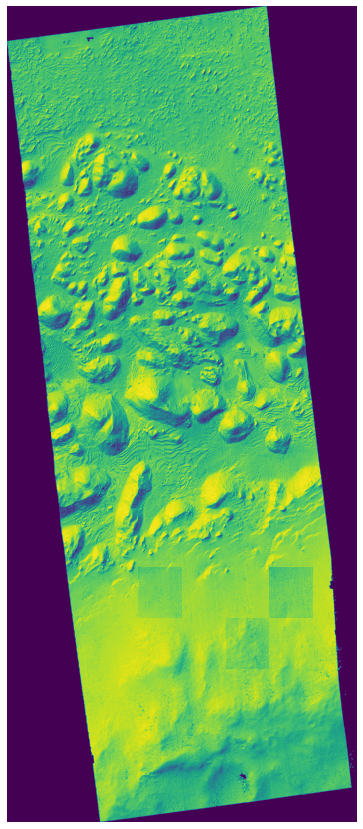

In [ ]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(16, 8),  # creates 32x16 grid of axes
                 axes_pad=0.0001,# pad between axes in inch.
                 direction = "column"
                 )

for ax, im in zip(grid, dems):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.imshow(im)

plt.show()

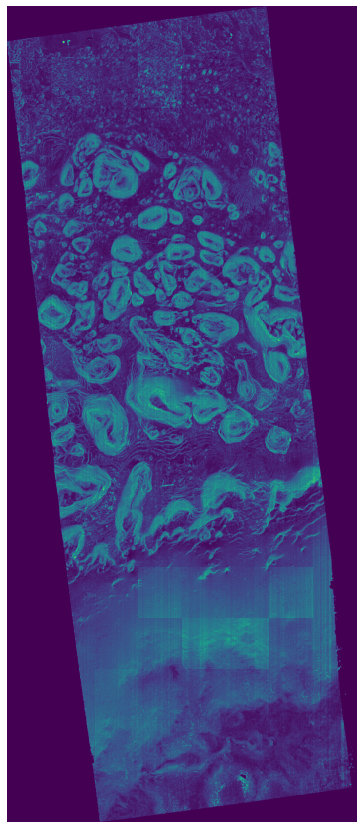

In [ ]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(16, 8),  # creates 32x16 grid of axes
                 axes_pad=0.0001,# pad between axes in inch.
                 direction = "column"
                 )

for ax, im in zip(grid, slopes):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.imshow(im)

plt.show()

In [ ]:
pred=[]
# dems = []
# slopes = []
for i in range(len(valid_dataset)):
  dem_array, mask_array = valid_dataset[i]  
  im = dem_array.unsqueeze(0).float()
  out =  FPN_3c_With_Gan.predict(im)
  out = out.squeeze().cpu().numpy()
  out[out >= 0.5] = 1
  out[out < 0.5] = 0
  pred.append(out)
  # dems.append(im.squeeze().cpu().numpy()[2])
  # slopes.append(im.squeeze().cpu().numpy()[1])
# print(np.unique(out))

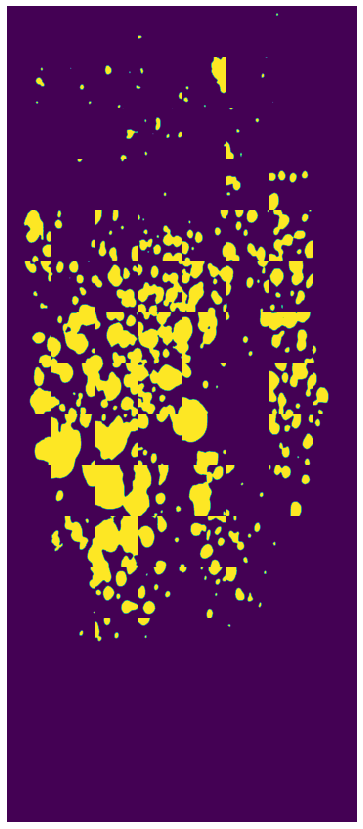

In [ ]:
fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(16, 8),  # creates 32x16 grid of axes
                 axes_pad=0.0001,# pad between axes in inch.
                 direction = "column"
                 )

for ax, im in zip(grid, pred):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.imshow(im)

plt.show()